# Overview of Distribution System Simulation using OpenDSS

## 🔍 Introduction to Distribution System Simulation
A distribution system in power system refers to the network that delivers electricity from the transmission system to end consumers. It typically operates at medium and low voltages (1 kV to 35 kV for medium, <1 kV for low) and includes feeders, distribution transformers, lines, switches, capacitor banks, and protective devices. Distribution system simulation can help to provide the distribution operators to operate and planning the distribution network reliably. They can provide operational quantities such as current, voltage, and power of lines and buses. Moreover, it helps to evaluate the performance of system and detect the potential issues in the system. Tools such as OpenDSS, GridLAB-D are used for simulation purpose. In this module, we will introduce how to perform distribution simulation with a open source tool which has a Python interface with OpenDSS.

### Why Perform  Distribution System Simulation?
- To perform the load flow analysis to create voltage profiles, line flows and losses in Distribution Network.
- To conduct fault studies for protection system design.
- To perform a reliability assesment such as model outages, and contintgency scenarios
- To evaluate distributed energy resources (DERs) hosting capacity of disitribution network.
- To conduct impact analysis under the penetration of DER, electric vehicles (EVs), and storage.

### How is Distribution System Simulation Performed?

- Modeling the network: Model the network adding source bus, buses, line/cable, transformers, loads, generators, DERs. Define electrical characteristics of each component
- Define load models: For steady-state studies: use simplified constant power (P/Q) or ZIP load models.
-  Simulation Mode :Set the mode for simulaiton. For e.g SNAP denotes the snapshot power flow.
-  Monitoring :Monitors and EnergyMeters can log per-step values (V, I, P, Q, losses) for post-processing.
-  Analyzing Results: Observe the bus voltage, branch currents, transformer overloading, etc.


OpenDSS stands for Open-Source Distribution System Simulator. It’s an open-source, electric power distribution system simulation tool developed by EPRI (Electric Power Research Institute).

##  Simple Distribution Feeder Simulation Example
### 1. Install OpenDSSdirect.py
Install OpenDSSdirect.py using pip if not already installed.

In [105]:
!pip install OpenDSSDirect.py --quiet

### 2. Import Required Libraries
The libraries for distribution simulation and results visualization.

In [106]:
import opendssdirect as dss
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

### 3. Create Simple distribution network with DERs

In [107]:
def create_der_enabled_distribution_system():
    """
    Create a distribution system with integrated DERs.
    Based on IEEE 34-bus but with added solar and storage.
    """
    # Clear any existing circuit
    dss.Command('Clear')
    
    # Create base distribution system
    commands = [
        "New Circuit.DER_Test basekv=24.9 phases=3",
        
        # Simplified feeder
        "New Line.L1 bus1=sourcebus bus2=800 length=2 units=km",
        "New Line.L2 bus1=800 bus2=802 length=1 units=km",
        "New Line.L3 bus1=800 bus2=806 length=1.5 units=km",
        "New Line.L4 bus1=802 bus2=808 length=0.5 units=km",
        
        # Traditional loads
        "New Load.L1 bus1=802 kV=24.9 kW=500 kvar=100 model=1",
        "New Load.L2 bus1=806 kV=24.9 kW=800 kvar=200 model=1",
        "New Load.L3 bus1=808 kV=24.9 kW=300 kvar=80 model=1",
        
        # Solar PV systems
        "New Generator.PV1 bus1=802 kV=24.9 kW=200 pf=1.0 model=7",  # 200 kW at bus 802
        "New Generator.PV2 bus1=806 kV=24.9 kW=200 pf=1.0 model=7",  # 100 kW at bus 806
        
        # Voltage regulation
        "Set Voltagebases=[24.9]",
        "Calcvoltagebases"
    ]
    
    for cmd in commands:
        dss.Command(cmd)
    
    # Set control mode
    dss.Command("Set Mode=Snap")
    dss.Command("Set ControlMode=Static")
    
    return commands


  

# Create and visualize the system
print("Creating DER-enabled distribution system...")
create_der_enabled_distribution_system()
# Solve and show initial conditions
dss.Command("Solve")
print("\nInitial System Conditions:")
print(f"Net Load: {-dss.Circuit.TotalPower()[0]:.1f} kW")

Creating DER-enabled distribution system...

Initial System Conditions:
Net Load: 1200.4 kW


### 4. Run Simulation with Load Variation 

In [108]:
consistent_random_object = np.random.RandomState(981)
load_profile_random = consistent_random_object.normal(1,0.025, 15) 

T = len(load_profile_random)
# Get node order once 
node_names = dss.Circuit.AllNodeNames()
N = len(node_names)
# --- store original kW before loop ---
original_loads = {}
for name in load_names:
    dss.Loads.Name(name)
    original_loads[name] = dss.Loads.kW()  # store original value
    
# Storage for per-node per-unit voltages over time
Vpu = np.zeros((T, N))

# Main loop for 15s simulation
for t in range(T):
    scale = load_profile_random[t]

    # Apply scaling to original loads
    for name in load_names:
        dss.Loads.Name(name)
        dss.Loads.kW(original_loads[name] * scale)

    dss.Solution.Solve()

    # store per-node voltage in per unit
    Vpu[t, :] = dss.Circuit.AllBusMagPu()

# Create DataFrame for analysis/plotting
Vpu_df = pd.DataFrame(Vpu, columns=node_names)


### 5. Plot the voltages

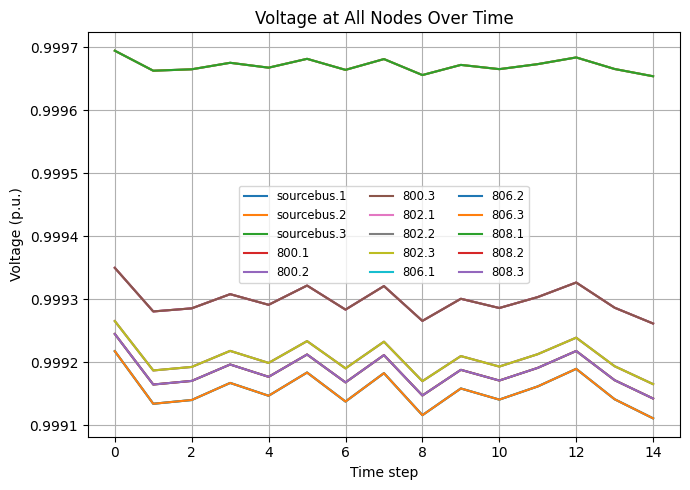

In [109]:
plt.figure(figsize=(7, 5))

# Plot all node voltages
for col in Vpu_df.columns:
    plt.plot(Vpu_df.index, Vpu_df[col], label=col)

plt.xlabel("Time step")
plt.ylabel("Voltage (p.u.)")
plt.title("Voltage at All Nodes Over Time")
plt.grid(True)
plt.legend(loc="best", fontsize="small", ncol=3)  
plt.tight_layout()
plt.show()


### 6. Run Simulation with DER power variation 

In [110]:
# Get the random profile with 5% std for DER
DER_profile_random = consistent_random_object.normal(1, 0.05, 15) 
# Get original PV ratings (kW) once
base_pv_kw = {}
for pv_name in ["PV1", "PV2"]:
    dss.Generators.Name(pv_name)
    base_pv_kw[pv_name] = dss.Generators.kW()

# Get node names once
node_names = dss.Circuit.AllNodeNames()
N = len(node_names)

# Store 
pv1_kw_list = []
pv2_kw_list = []
Vpu_all_steps = np.zeros((len(DER_profile_random), N))

# Loop over 15 steps
for t, scale in enumerate(DER_profile_random):
    
    # Scale both PVs from their original rating
    for pv_name in ["PV1", "PV2"]:
        dss.Generators.Name(pv_name)
        dss.Generators.kW(base_pv_kw[pv_name] * scale)

    # Solve power flow
    dss.Solution.Solve()

    # Store PV outputs
    dss.Generators.Name("PV1")
    pv1_kw_list.append(dss.Generators.kW())
    dss.Generators.Name("PV2")
    pv2_kw_list.append(dss.Generators.kW())

    # Store voltage magnitudes (p.u.)
    Vpu_all_steps[t, :] = dss.Circuit.AllBusMagPu()

# Create DataFrames
df_pv = pd.DataFrame({"PV1_kW": pv1_kw_list, "PV2_kW": pv2_kw_list})
df_vpu = pd.DataFrame(Vpu_all_steps, columns=node_names)



### 7. Plot DER active power putput

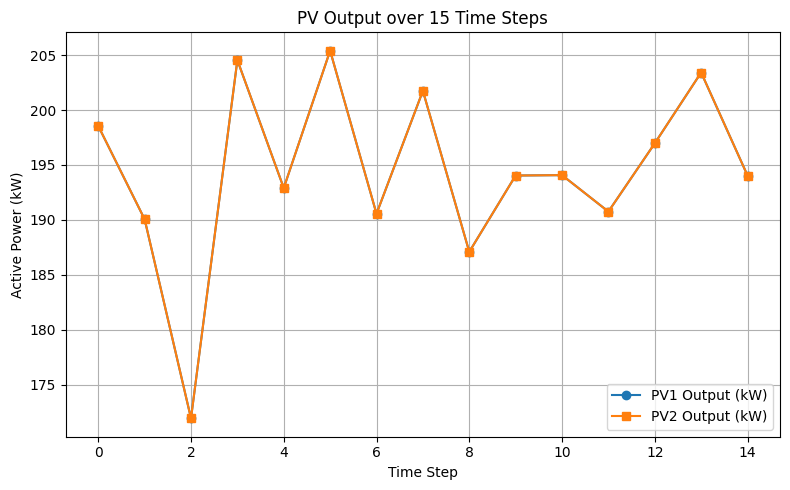

In [111]:
# ====== Plot PV active power outputs ======
plt.figure(figsize=(8, 5))
plt.plot(df_pv.index, df_pv["PV1_kW"], marker='o', label="PV1 Output (kW)")
plt.plot(df_pv.index, df_pv["PV2_kW"], marker='s', label="PV2 Output (kW)")
plt.xlabel("Time Step")
plt.ylabel("Active Power (kW)")
plt.title("PV Output over 15 Time Steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 7. Plot Voltage Response

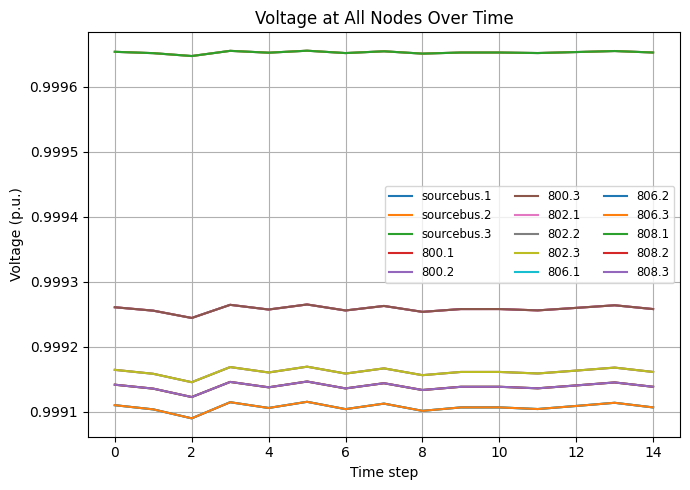

In [112]:
plt.figure(figsize=(7, 5))

# Plot all node voltages
for col in df_vpu.columns:
    plt.plot(df_vpu.index, df_vpu[col], label=col)

plt.xlabel("Time step")
plt.ylabel("Voltage (p.u.)")
plt.title("Voltage at All Nodes Over Time")
plt.grid(True)
plt.legend(loc="best", fontsize="small", ncol=3)  
plt.tight_layout()
plt.show()


In this demo distribution simulation, we performed the timeseries analysis of distribution network with load and DER power variations. The buses voltage following the load variations are shown. 

---

## 📚 References
- OpenDSS: https://opendss.epri.com/IntroductiontoOpenDSS.html
- OpenDSSdirect.py: https://dss-extensions.org/OpenDSSDirect.py/notebooks/Installation.html
---

## ✅ Done!
This example demonstrates how to simulate a distribution system usng OpenDSSdirect.py.
